Lane Detection

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('lanes.png')
lane_image = np.copy(image)
gray = cv2.cvtColor(lane_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
canny = cv2.Canny(blur, 50,100)

def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
    [(1500, height),(2400,2600),(3500, 2600),(4500,height) ]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

cropped_image = region_of_interest(canny)

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image
    
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=5, maxLineGap=70)
line_image = display_lines(lane_image, lines)

combo_image = cv2.addWeighted(lane_image, 0.6, line_image, 1,1)

def make_coordinates(image, line_parameters):
    slope,intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2),(y1,y2),1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis =0)
    right_fit_average = np.average(right_fit, axis =0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line,right_line])

averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

combo_image2 = cv2.addWeighted(lane_image, 0.4, line_image, 1,1)



Edge Point Detection

Edges: (2696, 2679) and (3161, 2686)


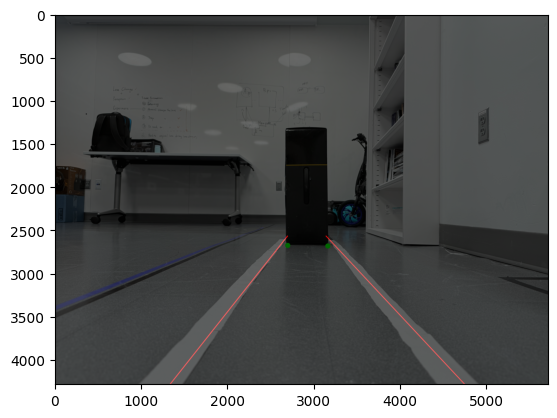

In [5]:
image_edge = cv2.imread("lanes.png")


def region_of_interest_edge(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

height, width = image.shape[:2]

roi_vertices = [
    (0, 3120),  # Left base point
    (3603,3120),  # Right base point
    (1900, 1500)  # Top vertex
]

# Apply triangular mask
cropped_image_edge = region_of_interest_edge(image_edge, np.array([roi_vertices]))

# Apply Canny edge detection on the cropped image
cropped_image_edge = cv2.cvtColor(cropped_image_edge, cv2.COLOR_BGR2GRAY)
cropped_image_edge = cv2.GaussianBlur(cropped_image_edge, (9, 9), 0)
edges_edge = cv2.Canny(cropped_image, 100, 400)
kernel_edge = np.ones((5, 5), np.uint8)
edges_edge = cv2.dilate(edges_edge, kernel_edge, iterations=3)
plt.imshow(edges_edge, cmap='gray')

contours, _ = cv2.findContours(edges_edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

img_2 = lane_image
def find_longest_horizontal_line(contours):
    longest_line = None
    max_length = 0

    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.001 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Loop through the contour segments to find horizontal lines
        for i in range(len(approx) - 1):
            x1, y1 = approx[i][0]
            x2, y2 = approx[i + 1][0]

            # Check if the line is horizontal (y1 approximately equals y2)
            if abs(y1 - y2) < 60:  # Later increase the threshold to allow the detection of crooked lines as well
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # Calculate the length of the line

                # Check if this is the longest line
                if length > max_length:
                    max_length = length
                    longest_line = [(x1, y1), (x2, y2)]

    return longest_line

longest_horizontal_line = find_longest_horizontal_line(contours)

if longest_horizontal_line is not None:
    (x1, y1), (x2, y2) = longest_horizontal_line
    cv2.circle(img_2, (x1, y1), 30, (0, 255, 0), -1)
    cv2.circle(img_2, (x2, y2), 30, (0, 255, 0), -1)
    print(f"Edges: ({x1}, {y1}) and ({x2}, {y2})")
else:
    print("No horizontal line detected.")

combo_image2 = cv2.addWeighted(img_2, 0.4, line_image, 1,1)
plt.imshow( combo_image2, cmap='gray')
plt.show()


Intel Realsense Code

In [6]:
#Set up camera
import pyrealsense2 as rs
import numpy as np


class DepthCamera:
    def __init__(self):
        self.pipeline = rs.pipeline()
        config = rs.config()

        # Get device product line for setting a supporting resolution
        pipeline_wrapper = rs.pipeline_wrapper(self.pipeline)
        pipeline_profile = config.resolve(pipeline_wrapper)
        device = pipeline_profile.get_device()
        device_product_line = str(device.get_info(rs.camera_info.product_line))


        config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
        #config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
        # Start streaming
        self.pipeline.start(config)


    def get_frame(self):
        frames = self.pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        #color_frame = frames.get_color_frame()


        depth_image = np.asanyarray(depth_frame.get_data())
        #color_image = np.asanyarray(color_frame.get_data())
        #if not depth_frame or not color_frame:
        if not depth_frame:
            return False, None, None
        #return True, depth_image, color_image
        return True, depth_image

    def release(self):
        self.pipeline.stop()


In [8]:
dc = DepthCamera()

while True:
    ret,depth_frame = dc.get_frame()
    point_1 = (x1,y1)
    Point_2 = (x2,y2)
    distance = depth_frame[point[1],point[0]]
    print(distance)
    key = cv2.waitkey(1)
    if key == 27:
        break

RuntimeError: No device connected

No horizontal line detected within the lane.


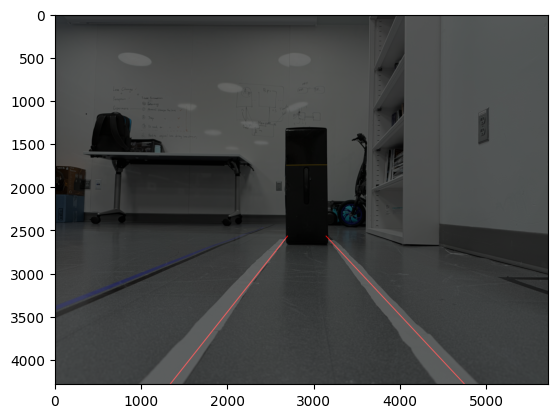